<a href="https://colab.research.google.com/github/Patelzeelr/Boston-Housing-Data/blob/main/Ay6110_mod1_lab1_patel_zeel_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d1306936cbc801371ca43340c964654a0b8322effcf61ff6f5bf53ba9e33078e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from google.colab import files
uploaded_files = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, mean, stddev, min, max, sum as spark_sum
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Start a Spark session
spark_session = SparkSession.builder.appName("BostonHousingAnalysis").getOrCreate()

# Load the dataset
file_path = "BostonHousing.csv"
data = spark_session.read.csv(file_path, header=True, inferSchema=True)

In [5]:
# Step 1: Show the first 5 elements of the dataset
data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [6]:
# Step 2: Count the number of observations in the dataset
count = data.count()
print(f"Number of observations: {count}")

# Number of rows
print("Number of rows:", data.count())
# Number of columns
print("Number of columns:", len(data.columns))

Number of observations: 506
Number of rows: 506
Number of columns: 14


In [7]:
# Step 3: Show the Schema of the dataset
data.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [8]:
# Extra: Check for missing values in each column
missing_values = data.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in data.columns])
missing_values.show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



In [9]:
# Step 4: Drop the column "b" from the dataset
data = data.drop('b')

In [10]:
# Step 5: Round all of the numerical columns to two decimal places
numerical_cols = [col_name for col_name, dtype in data.dtypes if dtype == 'double']
for col_name in numerical_cols:
    data = data.withColumn(col_name, round(col(col_name), 2))

data.show(5)

+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+
|crim|  zn|indus|chas| nox|  rm| age| dis|rad|tax|ptratio|lstat|medv|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+
|0.01|18.0| 2.31|   0|0.54|6.58|65.2|4.09|  1|296|   15.3| 4.98|24.0|
|0.03| 0.0| 7.07|   0|0.47|6.42|78.9|4.97|  2|242|   17.8| 9.14|21.6|
|0.03| 0.0| 7.07|   0|0.47|7.19|61.1|4.97|  2|242|   17.8| 4.03|34.7|
|0.03| 0.0| 2.18|   0|0.46| 7.0|45.8|6.06|  3|222|   18.7| 2.94|33.4|
|0.07| 0.0| 2.18|   0|0.46|7.15|54.2|6.06|  3|222|   18.7| 5.33|36.2|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+
only showing top 5 rows



In [11]:
# Step 6: Create a new column (Age10) with a 10% increase of the 'age' column
data = data.withColumn('Age10', col('age') * 1.10)
data.show(5)

+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+------------------+
|crim|  zn|indus|chas| nox|  rm| age| dis|rad|tax|ptratio|lstat|medv|             Age10|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+------------------+
|0.01|18.0| 2.31|   0|0.54|6.58|65.2|4.09|  1|296|   15.3| 4.98|24.0| 71.72000000000001|
|0.03| 0.0| 7.07|   0|0.47|6.42|78.9|4.97|  2|242|   17.8| 9.14|21.6|             86.79|
|0.03| 0.0| 7.07|   0|0.47|7.19|61.1|4.97|  2|242|   17.8| 4.03|34.7| 67.21000000000001|
|0.03| 0.0| 2.18|   0|0.46| 7.0|45.8|6.06|  3|222|   18.7| 2.94|33.4|             50.38|
|0.07| 0.0| 2.18|   0|0.46|7.15|54.2|6.06|  3|222|   18.7| 5.33|36.2|59.620000000000005|
+----+----+-----+----+----+----+----+----+---+---+-------+-----+----+------------------+
only showing top 5 rows



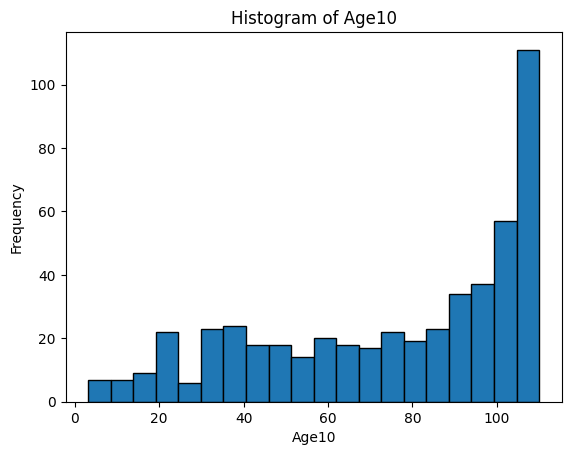

In [12]:
# Step 7: Plot histogram of the Age10 column on a 2D Plot
pd_df = data.select('Age10').toPandas()
plt.hist(pd_df['Age10'], bins=20, edgecolor='black')
plt.title('Histogram of Age10')
plt.xlabel('Age10')
plt.ylabel('Frequency')
plt.show()


In [13]:
# Step 8: Provide Summary Statistics of all columns (count, mean, stddev, min, max)
summary_stats = data.describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|               nox|                rm|               age|               dis|              rad|               tax|           ptratio|             lstat|              medv|             Age10|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|               506|               506|               506|               506|              

In [14]:
# Step 9: Convert Spark DataFrame to Pandas DataFrame
pd_df = data.toPandas()

In [15]:
# Step 10: Show the last 5 rows of the Pandas DataFrame
print(pd_df.tail())

     crim   zn  indus  chas   nox    rm   age   dis  rad  tax  ptratio  lstat  \
501  0.06  0.0  11.93     0  0.57  6.59  69.1  2.48    1  273     21.0   9.67   
502  0.05  0.0  11.93     0  0.57  6.12  76.7  2.29    1  273     21.0   9.08   
503  0.06  0.0  11.93     0  0.57  6.98  91.0  2.17    1  273     21.0   5.64   
504  0.11  0.0  11.93     0  0.57  6.79  89.3  2.39    1  273     21.0   6.48   
505  0.05  0.0  11.93     0  0.57  6.03  80.8  2.51    1  273     21.0   7.88   

     medv   Age10  
501  22.4   76.01  
502  20.6   84.37  
503  23.9  100.10  
504  22.0   98.23  
505  11.9   88.88  


# **EXTRA EDA**

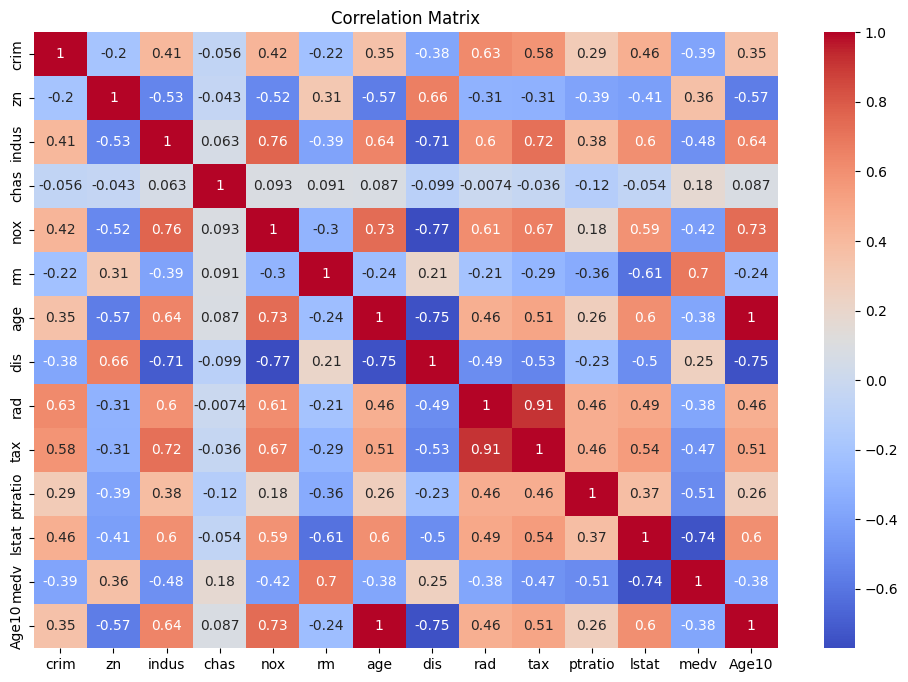

In [16]:
# Correlation Matrix
import seaborn as sns
plt.figure(figsize=(12, 8))
correlation_matrix = pd_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Based on the visualization, we can observe several strong and moderate correlations. The proportion of industrial land (INDUS) shows a strong positive correlation with nitric oxide concentration (NOX) at 0.76, indicating that areas with more industrial land tend to have higher NOX levels. On the other hand, the distance to employment centers (DIS) exhibits a strong negative correlation with NOX at -0.77, suggesting that areas farther from job hubs tend to have lower NOX concentrations.Furthermore, the accessibility to radial highways (RAD) correlates strongly positively with property tax rates (TAX) at 0.91, indicating that areas with better highway access typically have higher property taxes. Moreover, the median home value (MEDV) shows a strong positive correlation with the average number of rooms per dwelling (RM) at 0.7, suggesting that higher home values are associated with more rooms.Additionally, the percentage of lower status population (LSTAT) correlates strongly negatively with MEDV at -0.74, indicating that areas with higher proportions of lower status individuals tend to have lower median home values.



Examining housing and environmental data reveals key insights. Industrial land (INDUS) and radial highway accessibility (RAD) are strongly linked to higher nitric oxide concentration (NOX), highlighting environmental risks at the intersection of industry and transportation. Larger homes, measured by rooms per dwelling (RM), correlate positively with median home values (MEDV), indicating higher valuation for spacious residences. Conversely, neighborhoods with a higher percentage of lower status population (LSTAT) exhibit negative correlations with both MEDV and RM, suggesting lower housing quality and values in socioeconomically disadvantaged areas. Moreover, improved RAD access correlates with elevated property tax rates (TAX), reflecting heightened demand and infrastructure development in accessible regions.


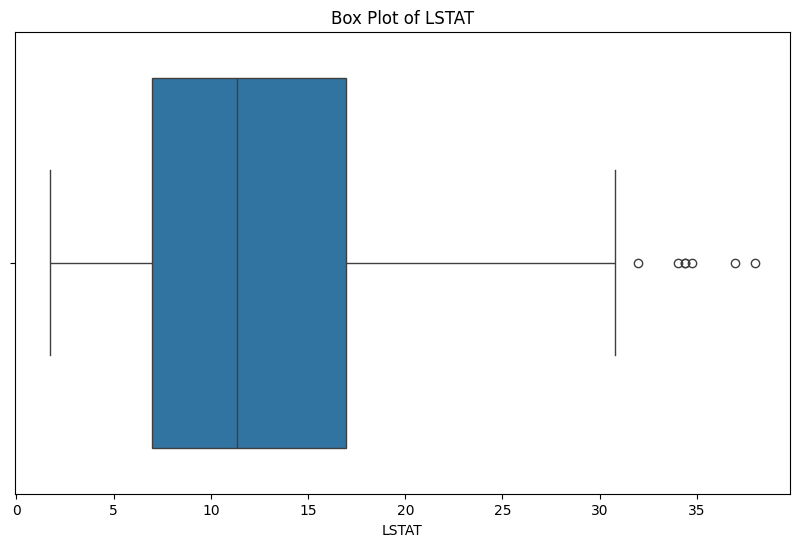

In [17]:
# Box plot for LSTAT (percentage of lower status of the population)
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd_df, x='lstat')
plt.title('Box Plot of LSTAT')
plt.xlabel('LSTAT')
plt.show()

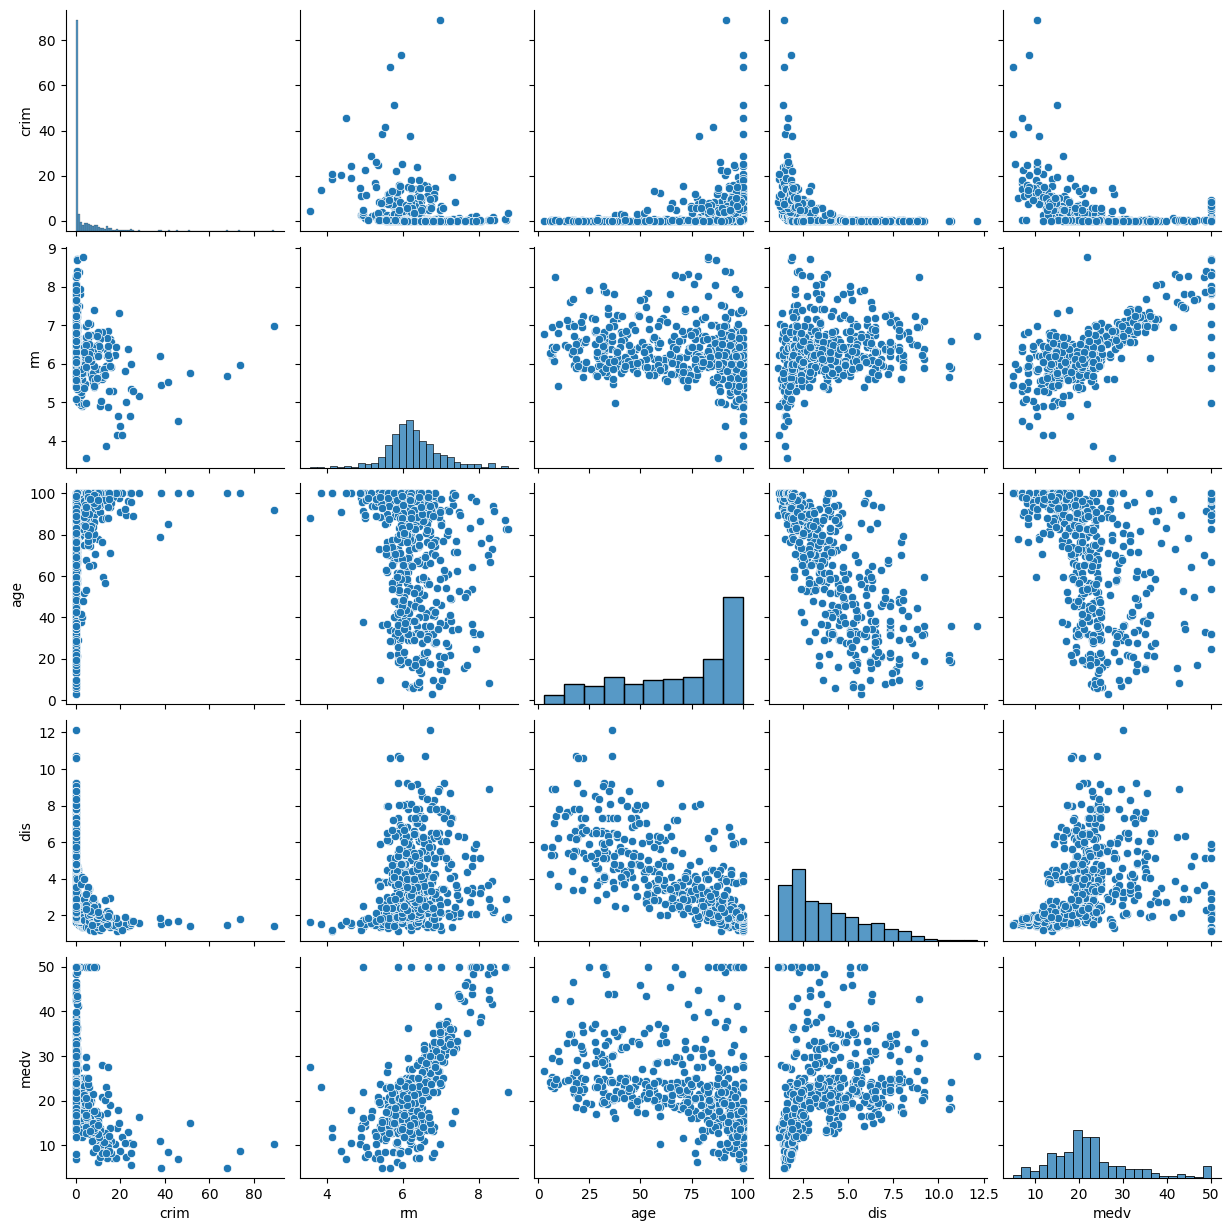

In [18]:
#Pair Plot
sns.pairplot(pd_df[['crim', 'rm', 'age', 'dis', 'medv']])
plt.show()

**CRIM**: Firstly, there is a clear negative correlation between crime rate and median home value (MEDV), indicating that higher crime rates are associated with lower property values. Areas with lower median home values tend to experience higher crime rates. Secondly, a negative relationship is observed between CRIM and the number of rooms per dwelling (RM), suggesting that neighborhoods with more spacious homes tend to have lower crime rates. Lastly, there is also a negative correlation between CRIM and distance to employment centers (DIS); towns located farther from job hubs tend to exhibit lower crime rates. These findings highlight how housing quality, urban planning, and economic factors influence crime rates in residential areas.

**Average** **number** **of** **rooms** **(RM):** There is a strong positive correlation between RM and median home value (MEDV), indicating that homes with more rooms tend to command higher prices. Conversely, RM shows a slight negative trend with the age of homes (AGE); older homes generally have fewer rooms. Additionally, there is a weak positive correlation between RM and distance to employment centers (DIS), suggesting that homes with more rooms may be slightly farther from job hubs. These insights underscore how the number of rooms influences both housing value and spatial considerations in residential areas.

**AGE**: There is a negative correlation between AGE and median home value (MEDV), indicating that older homes tend to have lower values. Secondly, AGE shows a negative correlation with distance to employment centers (DIS), suggesting that older homes are typically located closer to job hubs. These relationships highlight how the age of homes influences both their market value and their proximity to economic centers within residential areas.

**DIS**: There is a positive correlation between DIS and median home value (MEDV), indicating that homes situated farther from employment centers tend to command higher prices. Conversely, as previously noted, DIS shows a negative correlation with the proportion of older homes (AGE), suggesting that areas farther from job hubs tend to have newer housing stock. These relationships underscore how proximity to employment centers influences both housing values and the age composition of residential areas.

**MEDV**: There is a negative association between MEDV and crime rate (CRIM), indicating that areas with higher crime rates typically have lower home values. Conversely, MEDV shows a positive correlation with the average number of rooms per dwelling (RM), highlighting that larger homes tend to command higher prices. Additionally, there is a negative correlation between MEDV and the age of homes (AGE), as older properties generally have lower values. Moreover, homes located farther from employment centers (DIS) tend to exhibit higher MEDV values, emphasizing the influence of location on housing prices. These relationships underscore the multifaceted factors shaping median home values in residential real estate markets.


**Histogram:** The histograms of key variables reveal distinct distributions and insights into the dataset. The per capita crime rate (CRIM) histogram indicates that the majority of towns experience low crime rates, but there is a notable tail showing a few towns with exceptionally high crime rates. In contrast, the distribution of average number of rooms per dwelling (RM) appears relatively normal, centered around 6 rooms, suggesting a balanced distribution of housing sizes. The age of homes (AGE) histogram shows a bimodal distribution, with peaks at very old and relatively new homes, indicating fewer homes in the middle age range. Distance to employment centers (DIS) histogram reveals that most towns are clustered at shorter distances, suggesting a concentration of residential areas closer to job opportunities. Lastly, the median home value (MEDV) histogram exhibits a skewed distribution with a peak around $20,000 to $30,000, indicating that most towns have lower median home values, with a few outliers having significantly higher values. These visual representations provide a comprehensive overview of the dataset's housing and neighborhood characteristics.

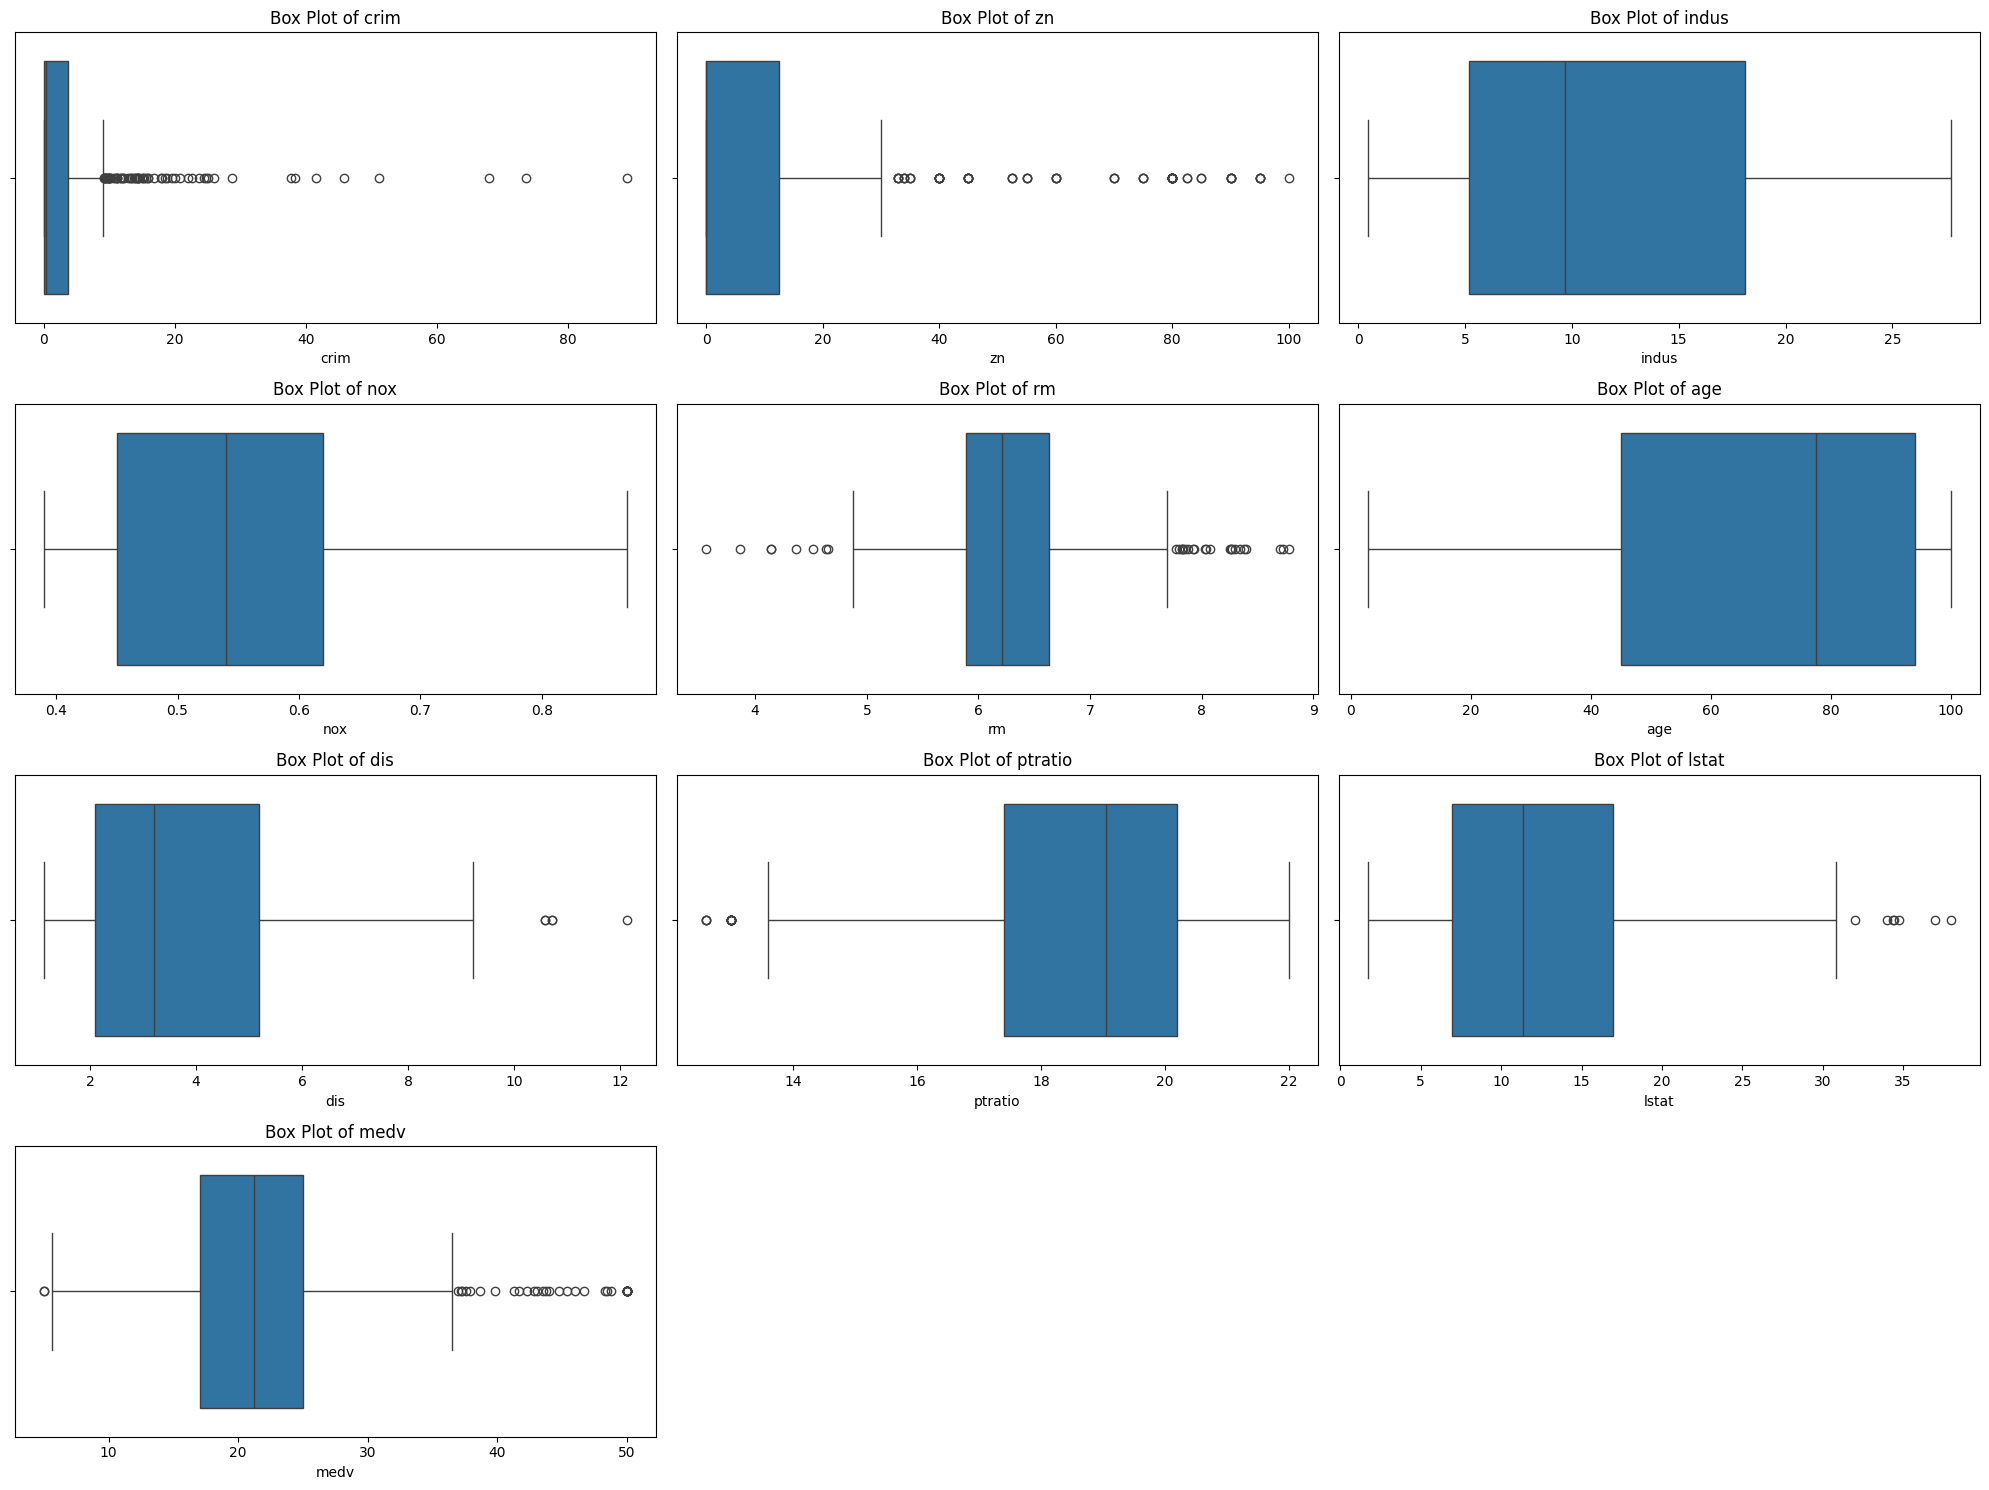

In [19]:
# Outlier Detection using Box Plots for all numerical columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i + 1)
    sns.boxplot(data=pd_df, x=col)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

**Box Plot of crim:** The crime rate variable has a median close to the lower part of the box, indicating a right-skewed distribution with many outliers on the higher end. This suggests that most towns have a low crime rate, with a few towns having much higher rates.

**Box Plot of zn:** The proportion of residential land zoned for lots over 25,000 sq. ft. also shows a right-skewed distribution, with many towns having a low proportion of such zoning, and a few towns having a higher proportion.

**Box Plot of indus:** The proportion of non-retail business acres per town has a median roughly in the middle of the box, with outliers on both ends, indicating a more balanced distribution but with some towns having significantly higher or lower proportions of industrial land.

**Box Plot of nox:** Nitric oxides concentration (parts per 10 million) shows a slightly left-skewed distribution with outliers on the lower end, suggesting that most towns have moderate to high pollution levels, with a few towns having particularly low levels.

**Box Plot of rm:** The average number of rooms per dwelling has a median that appears to be centrally located within the box, indicating a more symmetric distribution without extreme outliers, suggesting that the number of rooms is relatively consistent across towns.

**Box Plot of age:** The proportion of owner-occupied units built prior to 1940 shows a median towards the higher end of the box, indicating a right-skewed distribution with outliers on both ends, suggesting variation in the age of homes across towns.

**Box Plot of dis:** The weighted distances to five Boston employment centers show a right-skewed distribution with a few outliers on the higher end, indicating that most towns are relatively close to employment centers, with a few being much farther away.

**Box Plot of ptratio:** The pupil-teacher ratio by town has a median towards the lower end of the box, indicating a slight right skew with outliers on the higher end, suggesting that most towns have a relatively low pupil-teacher ratio, with a few having higher ratios.

**Box Plot of lstat:** The percentage of the lower status population has a median that is centrally located and a few outliers on the higher end, indicating a balanced distribution with some towns having a particularly high percentage of lower status populations.

**Box Plot of medv:** The median value of homes shows a median value around the mid-20s, with a fairly symmetric distribution but several outliers on the higher end, indicating that while many towns have moderately priced homes, there are a few with significantly higher home values.

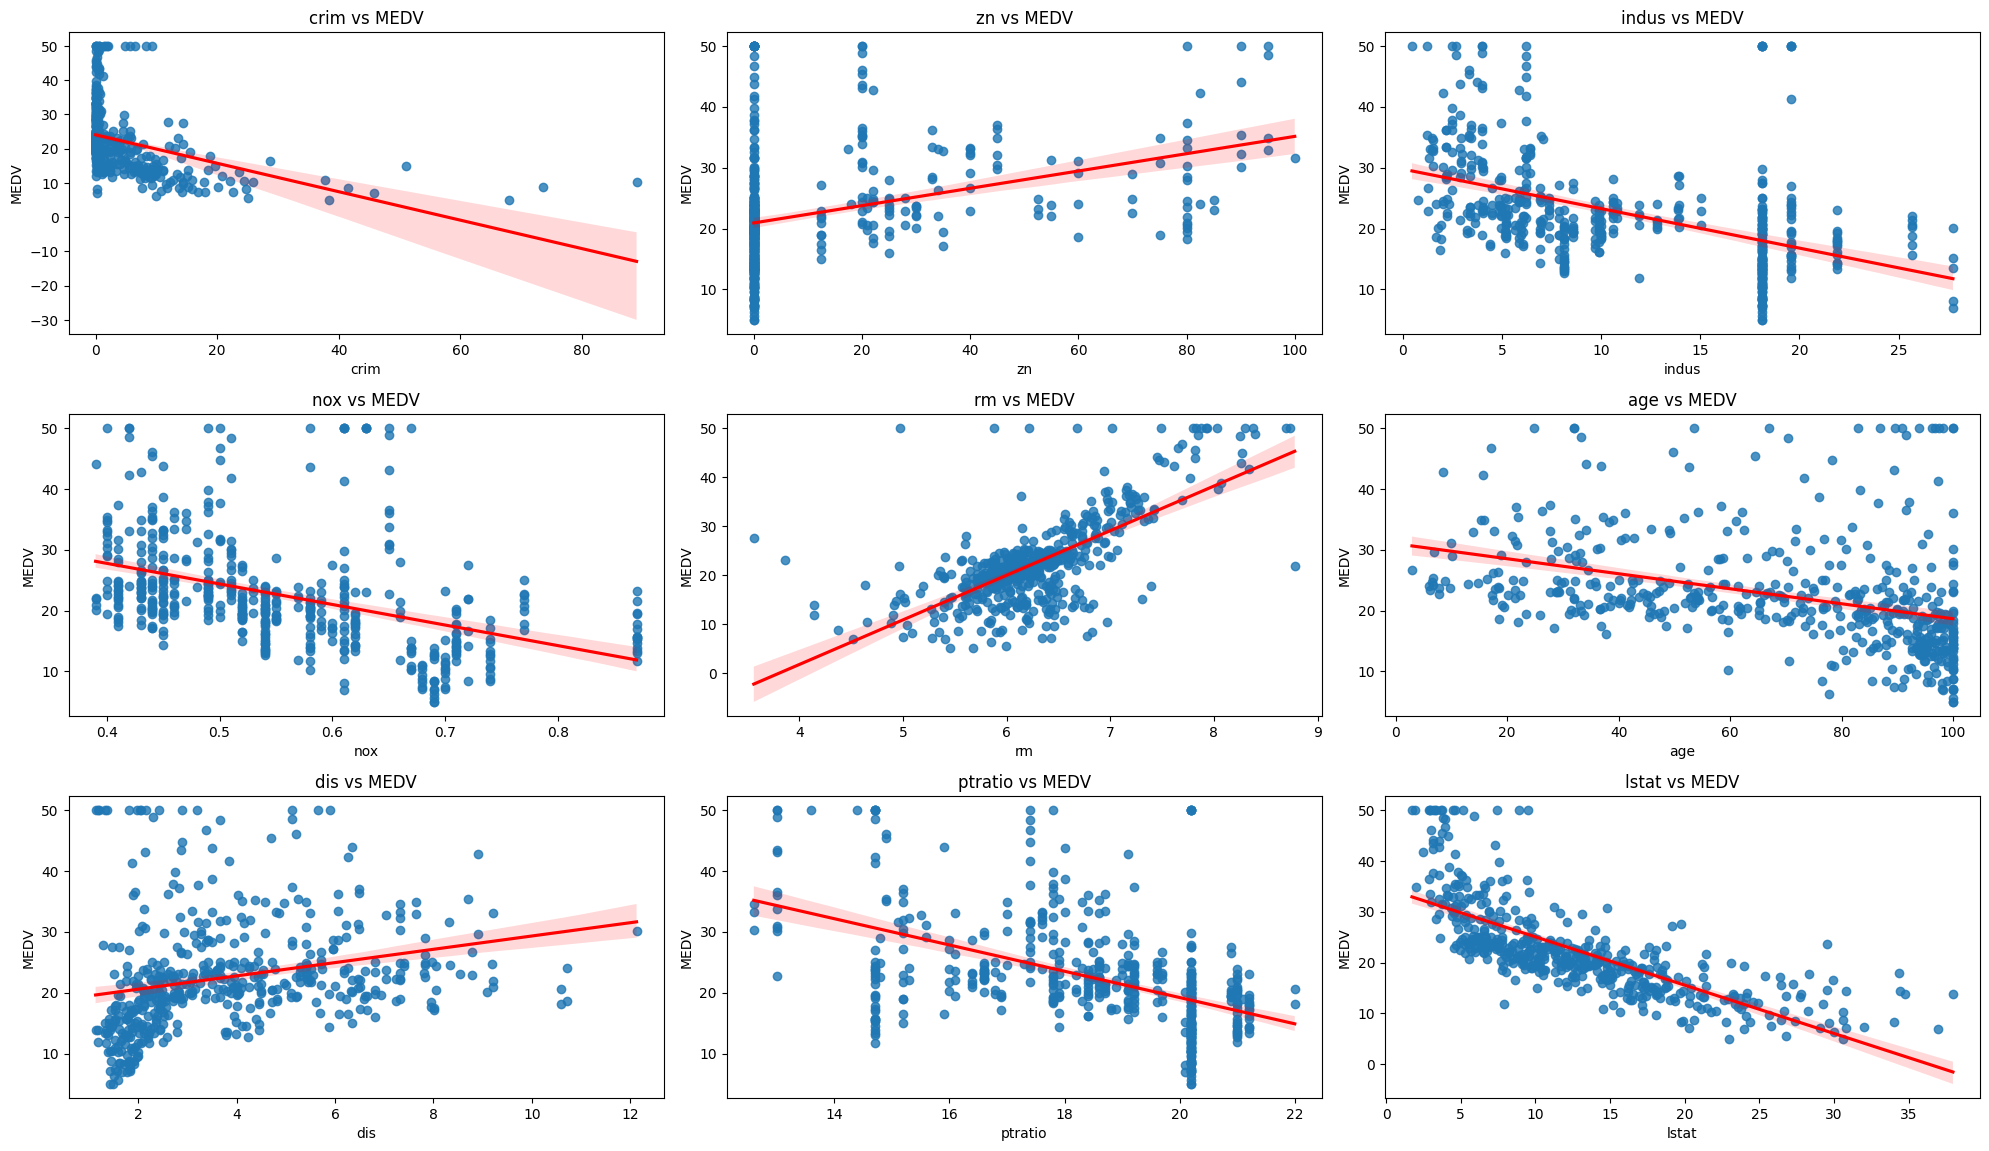

In [20]:
# Bivariate Analysis using Scatter Plots with Regression Lines for all numerical columns vs 'medv'
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    if col != 'medv':  # Avoid plotting medv vs medv
        plt.subplot(len(numerical_cols) // 3 + 1, 3, i + 1)
        sns.regplot(data=pd_df, x=col, y='medv', line_kws={"color": "red"})
        plt.title(f'{col} vs MEDV')
        plt.xlabel(col)
        plt.ylabel('MEDV')
plt.tight_layout()
plt.show()

**crim vs MEDV**: This plot indicates a negative correlation between the crime rate and the median value of homes, suggesting that as the crime rate increases, the median home value tends to decrease.

**zn vs MEDV**: Represents the proportion of residential land zoned for lots over 25,000 sq.ft. vs MEDV. It seems to show a weak positive correlation, indicating that larger residential zoning can be associated with higher median home values.

**indus vs MEDV**: This plot illustrates the proportion of non-retail business acres per town vs MEDV. There's a negative correlation, with more industrial land correlating with lower home values.

**nox vs MEDV**: Illustrates a negative correlation between nitric oxides concentration (parts per 10 million) and MEDV, implying that higher pollution levels are associated with lower home values.

**rm vs MEDV**: Depicts the average number of rooms per dwelling vs MEDV. There's a strong positive correlation, suggesting that houses with more rooms tend to be more valuable.

**age vs MEDV**: Represents the proportion of owner-occupied units built prior to 1940 vs MEDV. There's a negative correlation, indicating that older houses tend to be less valuable, possibly due to being outdated or requiring more maintenance.

**dis vs MEDV**: Shows the weighted distances to five Boston employment centers vs MEDV. There's a positive correlation, indicating that proximity to employment centers may increase home values.

**ptratio vs MEDV**: Represents the pupil-teacher ratio by town vs MEDV. A negative correlation is visible, suggesting that a lower pupil-teacher ratio, which may indicate better education resources, is associated with higher home values.

**lstat vs MEDV**: Depicts the percentage of lower status of the population vs MEDV. There's a strong negative correlation, indicating that areas with a higher proportion of "lower status" populations tend to have lower home values.